In [24]:
import numpy as np
import pandas as pd

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
import yfinance as yf

DX = yf.Ticker("DX-Y.NYB")
raw_data = DX.history(period = 'max')['Close']
raw_data.loc['2020'::]

Date
2020-01-02    96.849998
2020-01-03    96.839996
2020-01-06    96.669998
2020-01-07    96.980003
2020-01-08    97.300003
                ...    
2021-09-02    92.230003
2021-09-03    92.040001
2021-09-07    92.519997
2021-09-08    92.650002
2021-09-09    92.637001
Name: Close, Length: 424, dtype: float64

<AxesSubplot:xlabel='Date'>

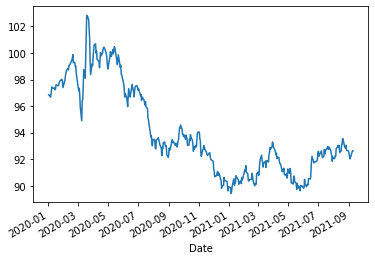

In [3]:
raw_data.loc['2020'::].plot()

In [4]:
def log_return(series):
    return np.log(series).diff()

In [5]:
raw_data = log_return(raw_data)[1::]

In [6]:
raw_data.min()

-0.05129333963229321

<AxesSubplot:xlabel='Date'>

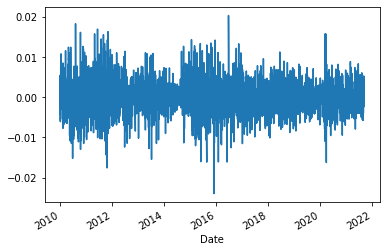

In [7]:
training_data = raw_data.loc['2010'::]
training_data.plot()

用create_seq將一個時間序列依想要訓練的長度  
拆成訓練資料與target  

In [8]:
#for plotting 
def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 1.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()



將單一變數的time-series拆成 n天為input_data, n+1天為target_value  
也就是我們希望用n天的報酬率資料，去預測再下一天n+1的報酬率  

In [9]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length ):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [10]:
x, y = create_sequences(training_data, 14)

In [11]:
#檢視一下這個create_sequences到底是怎麼運作的
print(f'原始data長度：{len(training_data)}')
print(f'create_sequence後data的長度{ len(x)}')

原始data長度：2919
create_sequence後data的長度2905


In [12]:
print(x[0]) # 第一個seq的input data
print(y[0]) # 第一個seq的target value
print(x[1]) # 第二個seq的input data 可以發現資料全部t+1 而第一個seq的target value變成第二個seq最新的一筆data

[-0.00424741  0.00116022 -0.00167629  0.00540549 -0.00566358 -0.00608536
 -0.0006496  -0.00130037 -0.00156264  0.00765984  0.00232529  0.01078035
 -0.00025529 -0.00051087]
-0.0011503335733697995
[ 0.00116022 -0.00167629  0.00540549 -0.00566358 -0.00608536 -0.0006496
 -0.00130037 -0.00156264  0.00765984  0.00232529  0.01078035 -0.00025529
 -0.00051087 -0.00115033]


In [13]:
#其data為一維 要小心
x[0].shape

(14,)

create_sequence第一筆資料為1~14天的報酬率，再用第15天的報酬率當成target  
因此我們在拆分train,vaild,test data時  
需將data 先用create_sequence跑過，再依想要train的資料筆數拆分  
(之前是先將data依照年份先拆分 如raw_data.loc['2020'].. 會使得資料有缺漏） 

In [14]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [15]:
class DX_dataset(Dataset):
    def __init__(self, data, mode = 'train'):
         
        #set data split    
        data = 100*data #先將data scale一下 原始報酬率資料數值都太小了
        #self.seq_length = config['seq_length']
        x,y = create_sequences(data, config['seq_length'])
        self.mode = mode
        self.test_data_length = config['test_data_length']
        self.train_data_length = len(data) - config['seq_length'] - self.test_data_length
        #用來test的資料數 300
        #用來vaild的資料數 20% of remaining training data
        
        if self.mode == 'test': #就是test mode的情況下
            #最後506筆data用來做test
            self.data = torch.FloatTensor(x[-self.test_data_length::])
            self.test_target = y[-self.test_data_length::] 
        
        else:  
            self.vaild_data_length = round(self.train_data_length * 0.8)
            if self.mode == 'train':
                self.data = torch.FloatTensor(x[0:self.vaild_data_length])
                self.target = torch.FloatTensor(y[0:self.vaild_data_length])
            elif self.mode == 'vaildation':
                self.data = torch.FloatTensor(x[self.vaild_data_length:self.train_data_length])
                self.target = torch.FloatTensor(y[self.vaild_data_length:self.train_data_length])
            
            #self.target = \
            #(self.target - self.target.mean(dim=0, keepdim=True)) \
            #/ self.target.std(dim=0, keepdim=True)
        
        #將train_data做標準化, target我們只有scale 100倍而已
        self.data = \
            (self.data - self.data.mean(dim=0, keepdim=True)) \
            / self.data.std(dim=0, keepdim=True)

        

    def __getitem__(self, index):
        
        if self.mode in ['train', 'vaildation']:
            # For training
            # 在不調整shape下，其getitim會得shape(14, )的值，絕對要避免用一維數組
            # ex batch_size = 3 , 則為 (3,14).... 但CNN要求的input為3D的tensor
            # 故用view(1,self.seq_length)使其getitim會得shape為(1,14) 的vector 
            # batch_size會自動為data增加一個維度
            
            return self.data[index].view(1,config['seq_length']), self.target[index]
        else:
            # For testing (no target)
            return self.data[index].view(1,config['seq_length'])
            
    def __len__(self): 
        # Returns the size of the dataset
        return len(self.data)

In [16]:
def prep_dataloader(data, mode, batch_size, n_jobs=0):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = DX_dataset(data, mode=mode)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=True,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

In [17]:
#用來檢視input data的dim
#data = prep_dataloader(training_data, mode= 'train',batch_size = 1)
#for x,y in data:
#    print(f'train_data: {x}, target : {y}')
#    print(f'train_data_shape : {x.shape}')
    

In [18]:
#用來試試看模型dim是否正確
#model = Model(1)
#test = torch.randn(30,1,14)
#pred = model(test)
#pred


In [19]:
#torch.flatten(pred)

In [20]:
#原本自己弄了一個naive的1d cnn 但效果很差 就直接把別人疊好的拿來用
class Conv1dBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(5,), stride=(1,), padding=(2,)):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, padding_mode='replicate', bias=True),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, padding_mode='replicate', bias=True),
            nn.BatchNorm1d(out_channels),
        )
        self.activation = nn.ReLU()
        
    def forward(self, x):
        output = self.conv_block(x)
        output = self.activation(output)
        return output
    # with kernel_size & padding , can make sure length of output eqauals to input array
    
class Model(nn.Module):
     def __init__(self, in_channels):
        super().__init__()
        self.conv_block1 = Conv1dBlock(in_channels=in_channels, out_channels=4)
        #self.conv_block6 = Conv1dBlock(in_channels=32, out_channels=16)
        #self.conv_block7 = Conv1dBlock(in_channels=16, out_channels=8)
        self.conv_block8 = Conv1dBlock(in_channels=4, out_channels=1)
        self.pooling = nn.AvgPool1d(kernel_size=(3,), stride=(1,), padding=(1,))
        
        self.net = nn.Sequential(
        nn.Linear(1 * config['seq_length']  ,56), #out_dim * seq_length * batch_size
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(56,1)
        )

        self.criterion = nn.MSELoss(reduction='mean')
     
     def forward(self, x):
        x = self.conv_block1(x)
        #x = self.pooling(x)
        #x = self.conv_block6(x)
        #x = self.pooling(x)
        #x = self.conv_block7(x)
        #x = self.pooling(x)
        x = self.conv_block8(x)
        #x = self.pooling(x)
        x = self.net(x)
        return x
    
     def cal_loss(self, pred, target):
        return self.criterion(pred, target)


In [32]:
#直接搬李鴻毅HW1的train過來改
def train(tr_set, dv_set, model, config):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero cleaning grad before
            pred = model(x)                     # forward pass (compute output)
            pred = torch.flatten(pred)
            #mse_loss =   # compute loss
            RMSE = torch.sqrt(model.cal_loss(pred, y))
            RMSE.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(RMSE.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.6f})'
                .format(epoch + 1, min_mse))
            #torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1
            #print(f'now epoch: {epoch + 1}, current loss = {min_mse}')

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record


def dev(dv_set, model):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            pred = torch.flatten(pred)
            RMSE = torch.sqrt(model.cal_loss(pred, y))  # compute loss
        total_loss += RMSE.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

def test(tt_set, model):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        with torch.no_grad():                   # disable gradient calculation
            
            pred = model(x)                     # forward pass (compute output)
            pred = torch.flatten(pred)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds



In [33]:
#optimizer 用Adam
config = {
    'n_epochs': 1000,                # maximum number of epochs
    'batch_size': 64,               # mini-batch size for dataloader
    'seq_length' : 28,
    'test_data_length':30,
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.01,                 # learning rate of SGD
        'weight_decay':1e-5,
        #'momentum': 0.9,             # momentum for SGD
    },
    'early_stop': 200             # early stopping epochs (the number epochs since your model's last improvement) # your model will be saved here
}


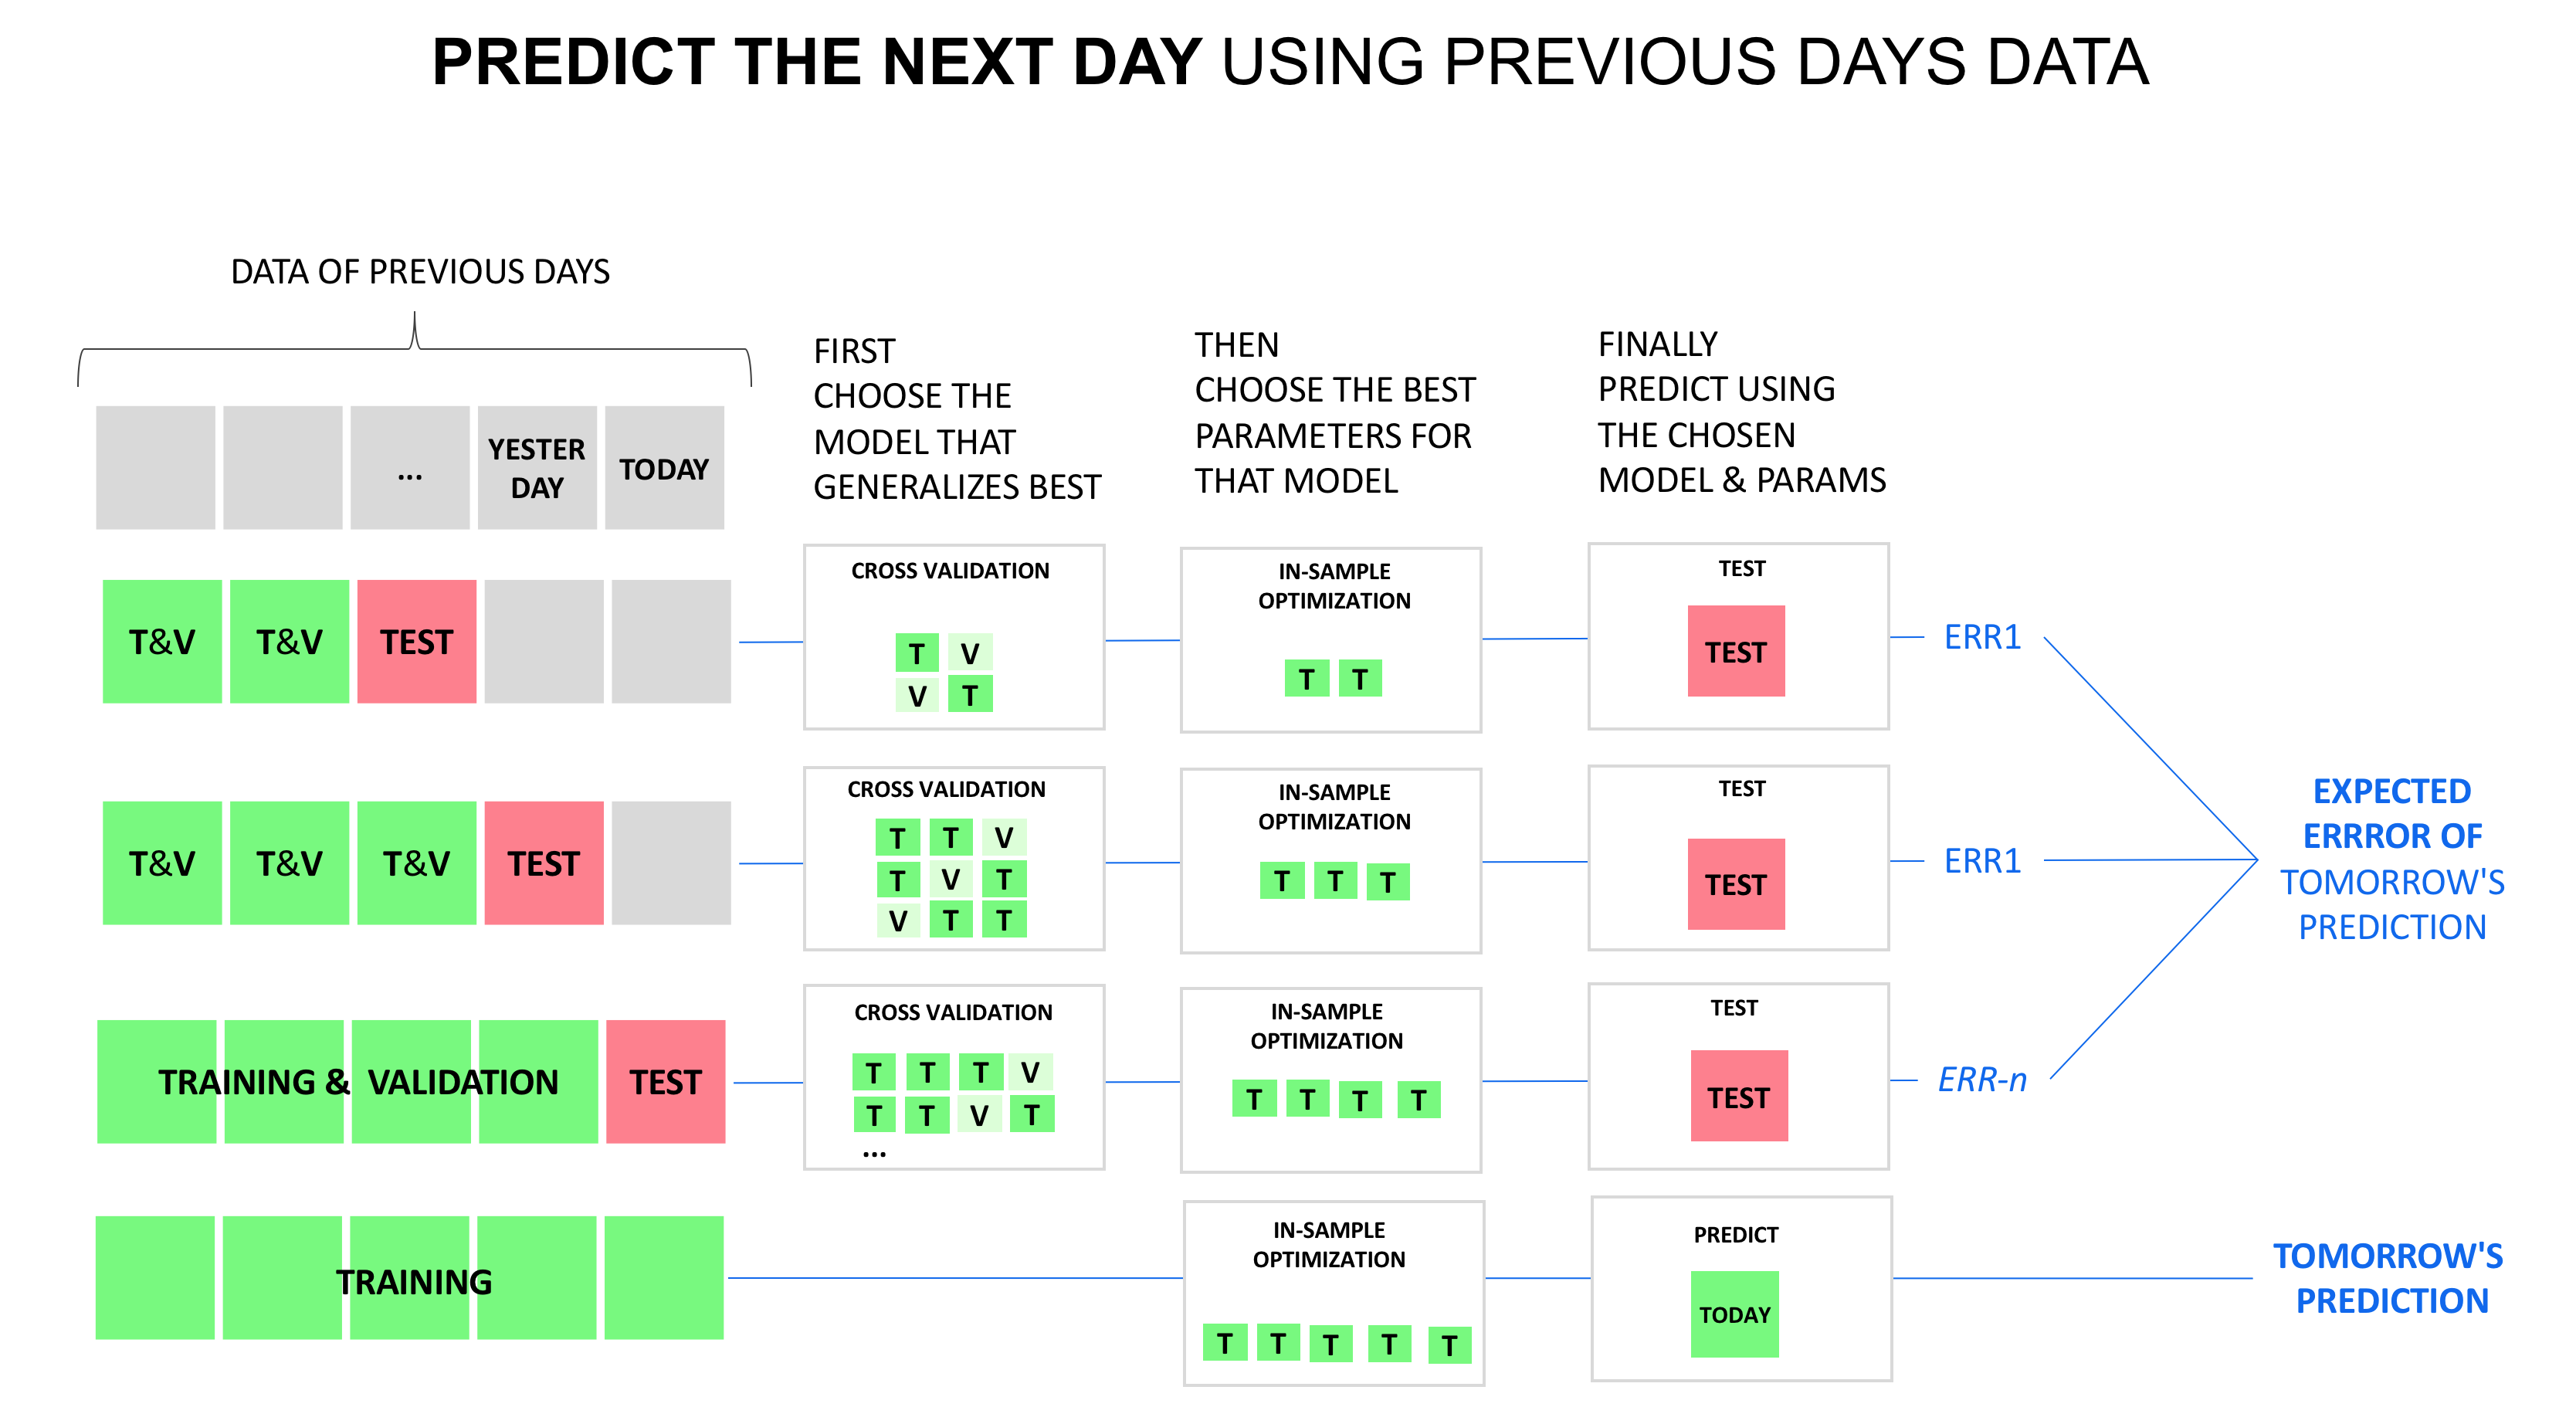

Saving model (epoch =    1, loss = 0.361715)
Saving model (epoch =    2, loss = 0.353583)
Saving model (epoch =    3, loss = 0.348919)
Finished training after 204 epochs


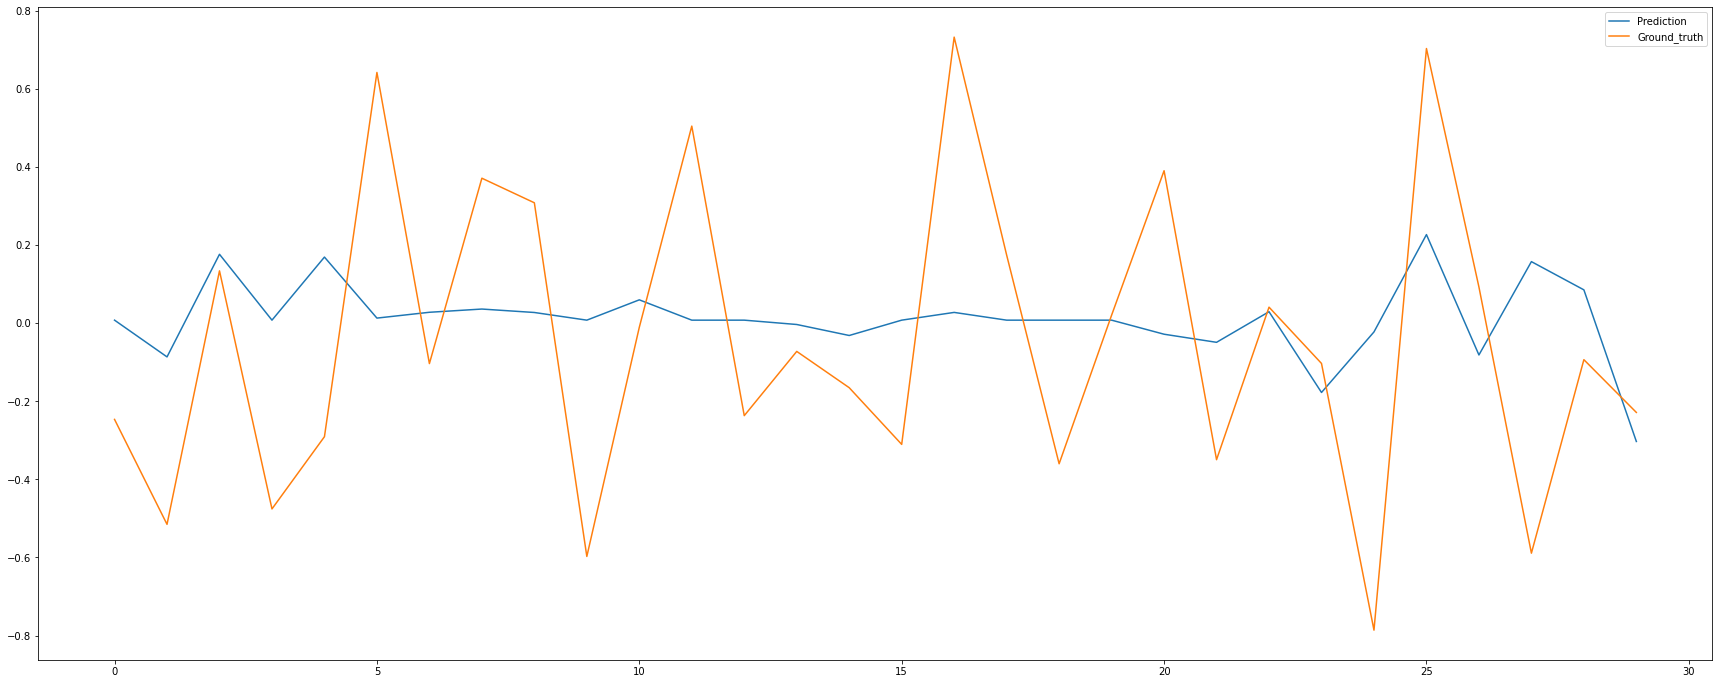

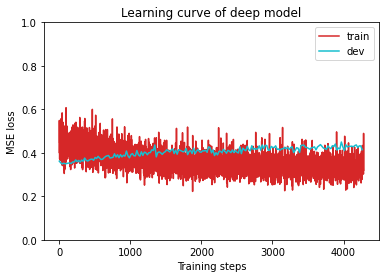

2018 最後30日的test_loss: 0.3860883414745331
--------------------------------------------------
Saving model (epoch =    1, loss = 0.320589)
Finished training after 202 epochs


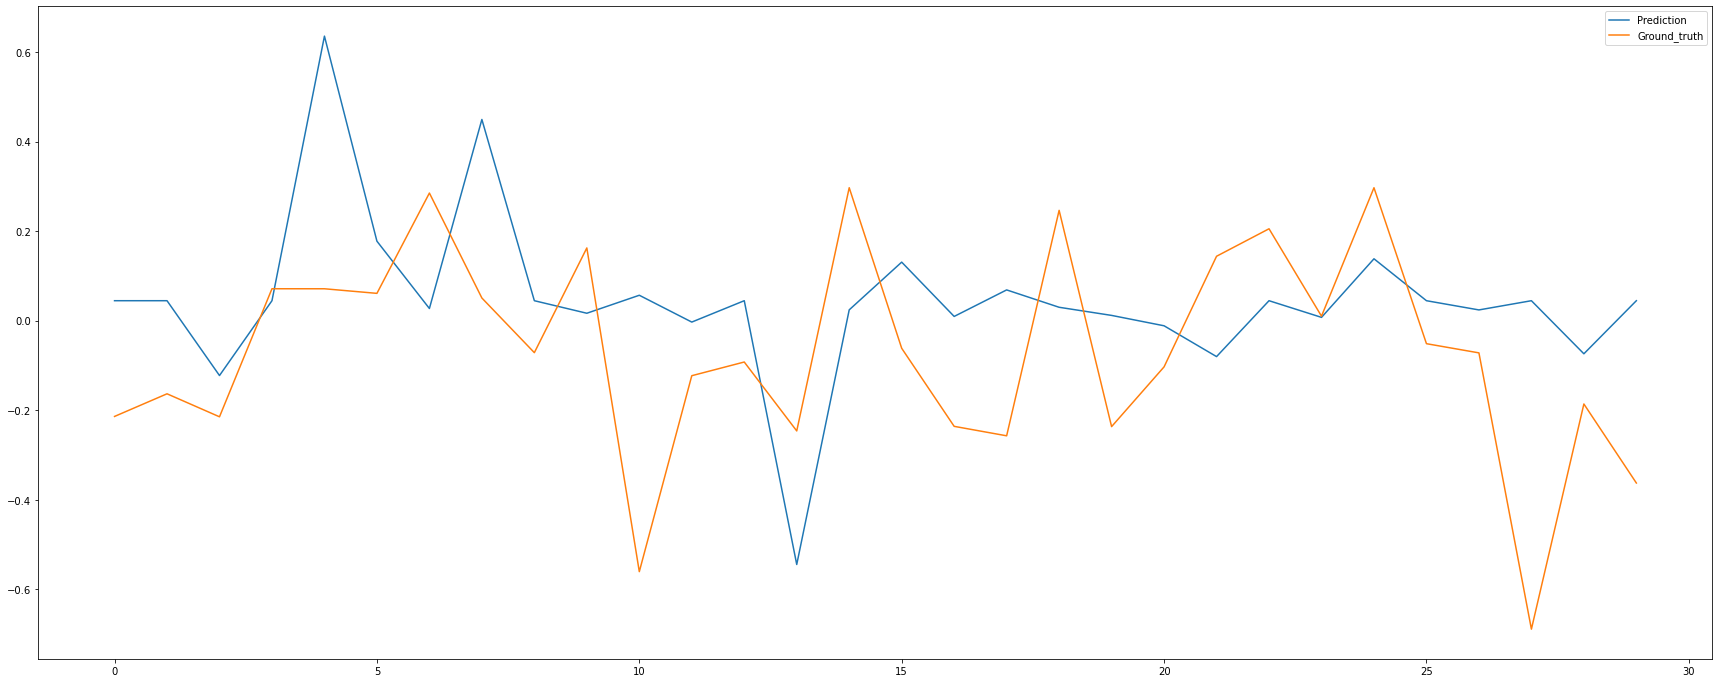

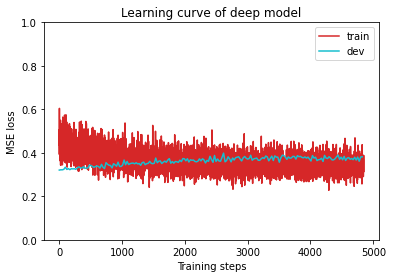

2019 最後30日的test_loss: 0.2855871021747589
--------------------------------------------------
Saving model (epoch =    1, loss = 0.314663)
Saving model (epoch =    2, loss = 0.313173)
Finished training after 203 epochs


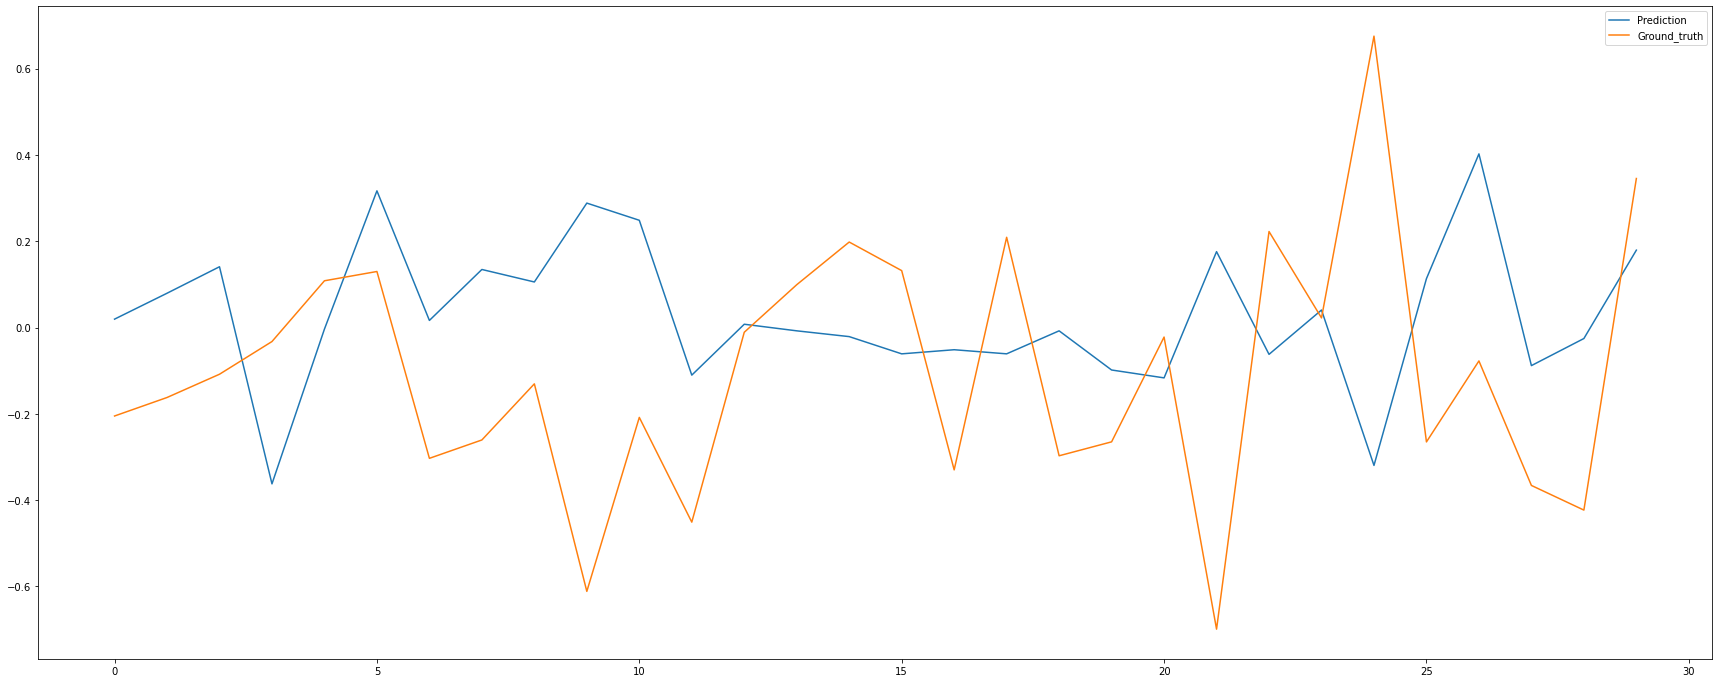

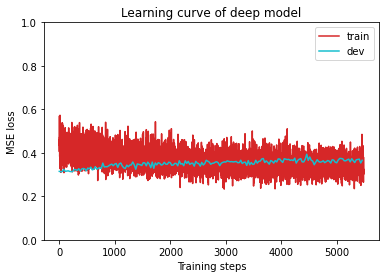

2020 最後30日的test_loss: 0.3922177851200104
--------------------------------------------------
Saving model (epoch =    1, loss = 0.362541)
Saving model (epoch =    2, loss = 0.362269)
Saving model (epoch =    6, loss = 0.361432)
Saving model (epoch =   13, loss = 0.361125)
Finished training after 214 epochs


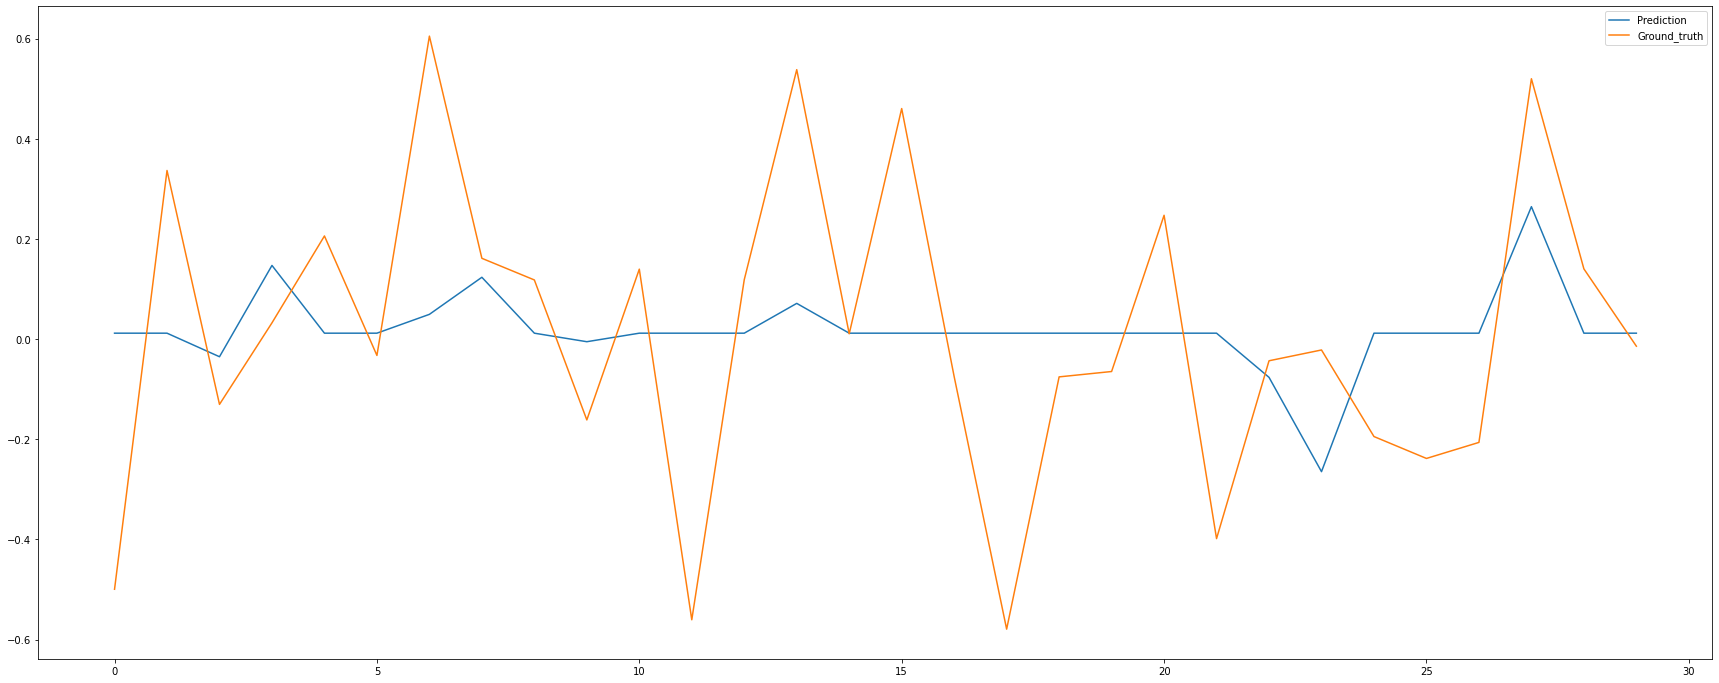

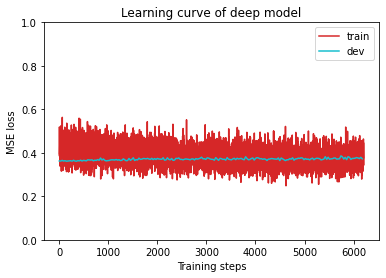

2021 最後30日的test_loss: 0.28516092896461487
--------------------------------------------------


In [34]:
#依據上面的方法spilt train val test data
#假使我們想預測的是最近30天的表現 
test_date = 30
#而training的部分 為2018年all >> test 2019/1 >> 2018~2019 all >> test 2020/1 >> 2018~2021/7 
# >>test til now
for year in range(18,22):
    dataset = raw_data.loc['2012':'20'+str(year)]
    tr_set = prep_dataloader(dataset, 'train', config['batch_size'])
    dv_set = prep_dataloader(dataset, 'vaildation', config['batch_size'])
    #input chan = 1
    model = Model(1)
    model_loss, model_loss_record = train(tr_set, dv_set, model, config)
    
    tt_set = prep_dataloader(dataset, 'test', batch_size = 1)
    preds = test(tt_set, model)
    
    result = pd.DataFrame(preds, columns = {'Prediction'})
    result['Ground_truth'] = 100 * dataset[-config['test_data_length']::].reset_index(drop = True)
    result.plot(figsize = (30,12))
    plot_learning_curve(model_loss_record, title='deep model')
    
    test_loss = torch.sqrt(model.cal_loss(torch.FloatTensor(result['Prediction']), torch.FloatTensor(result['Ground_truth'])))
    print(f'20{year} 最後30日的test_loss: {test_loss}')
    print('-' * 50)

In [48]:
tr_set = prep_dataloader(training_data, 'train', config['batch_size'])
dv_set = prep_dataloader(training_data, 'vaildation', config['batch_size'])

model = Model(1)
model_loss, model_loss_record = train(tr_set, dv_set, model, config)

Saving model (epoch =    1, loss = 0.127187)
Saving model (epoch =    3, loss = 0.125112)
Saving model (epoch =   10, loss = 0.125085)
Saving model (epoch =   74, loss = 0.125083)
Saving model (epoch =  249, loss = 0.125083)
Saving model (epoch =  304, loss = 0.125082)
Saving model (epoch =  437, loss = 0.125082)
Saving model (epoch =  480, loss = 0.125082)
Finished training after 681 epochs


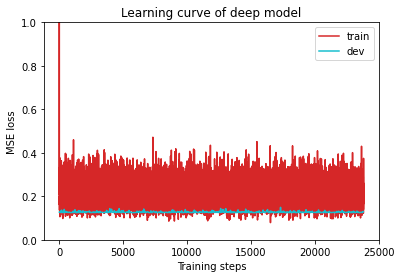

In [49]:
plot_learning_curve(model_loss_record, title='deep model')

In [264]:
a = dv_set.dataset.data[10].view(1,1,14)
preds = model(a) 

RuntimeError: shape '[1, 1, 14]' is invalid for input of size 7

In [50]:
#prediction時 batch_size = 1 
tt_set = prep_dataloader(training_data, 'test', 1)
preds = test(tt_set, model)
len(preds)
preds

array([-0.08656871, -0.08656871, -0.08656871, -0.08656871, -0.08656871,
       -0.08656871, -0.08656871, -0.08656871, -0.08656871, -0.08656871,
       -0.08656871, -0.08656871, -0.08656871, -0.08656871, -0.08656871,
       -0.08656871, -0.08656871, -0.08656871, -0.08656871, -0.08656871,
       -0.08656871, -0.08656871, -0.08656871, -0.08656871, -0.08656871,
       -0.08656871, -0.08656871, -0.08656871, -0.08656871, -0.08656871],
      dtype=float32)

In [51]:
tt_set.dataset.data.shape

torch.Size([30, 14])

In [155]:
for i in model.parameters():
    print(i)

Parameter containing:
tensor([[[-1.5861e-38,  2.2379e-40,  3.2030e-38,  2.9190e-38,  7.0673e-38]],

        [[-6.6738e-38,  2.7721e-39,  5.6181e-38,  2.9169e-38, -5.9562e-38]],

        [[ 1.3826e-38,  2.0863e-39, -2.9550e-38,  5.7082e-38,  3.8060e-39]],

        [[ 6.1925e-38,  5.4138e-38, -6.2622e-39,  4.4499e-38,  2.2110e-38]],

        [[ 6.3665e-38,  6.8057e-39, -2.4706e-38,  1.3294e-38, -2.8634e-38]],

        [[-2.0708e-39,  2.8602e-38,  6.0515e-39, -5.5578e-38,  3.8892e-38]],

        [[ 8.5455e-39,  6.3574e-38,  8.4580e-39,  1.0770e-38, -2.5949e-38]],

        [[ 2.0294e-38, -1.0828e-38, -2.7366e-38,  6.6281e-39,  3.1245e-38]],

        [[ 3.2823e-39,  1.7182e-39,  6.3900e-39,  7.1333e-39,  6.0426e-38]],

        [[-2.3332e-38,  2.7740e-38, -3.2049e-39,  1.9368e-38, -5.9088e-38]],

        [[ 3.2044e-39,  5.6945e-38,  1.9634e-38,  9.3025e-39,  1.6739e-38]],

        [[ 5.7429e-38,  2.3275e-38,  3.6665e-39,  2.6305e-38,  1.0490e-38]],

        [[ 1.4386e-38, -2.4794e-38,  2.091

<AxesSubplot:>

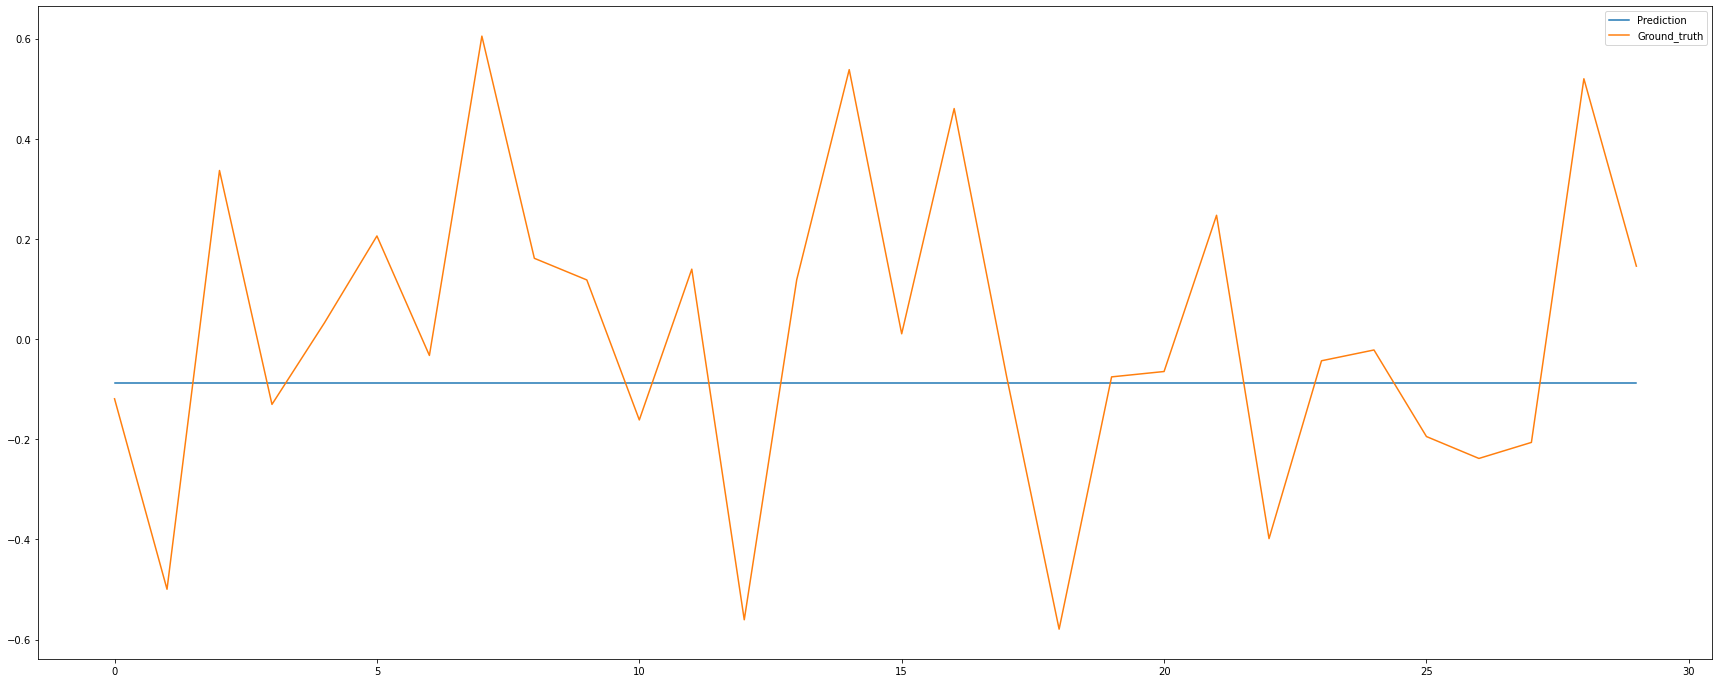

In [52]:
result = pd.DataFrame(preds, columns = {'Prediction'})
result['Ground_truth'] = 100 * raw_data[-config['test_data_length']::].reset_index(drop = True)
result.plot(figsize = (30,12))

In [53]:
#pred loss 
model.cal_loss(torch.FloatTensor(result['Prediction']), torch.FloatTensor(result['Ground_truth']))

tensor(0.0997)

In [319]:
result['Ground_truth']

0    -0.237736
1    -0.119081
2    -0.499511
3     0.336899
4    -0.130274
5     0.032584
6     0.206124
7    -0.032517
8     0.605282
9     0.161501
10    0.118274
11   -0.161310
12    0.139820
13   -0.560472
14    0.118823
15    0.538330
16    0.010739
17    0.460609
18   -0.074838
19   -0.579215
20   -0.075329
21   -0.064611
22    0.247454
23   -0.398380
24   -0.043165
25   -0.021594
26   -0.194511
27   -0.238243
28   -0.206222
29    0.482320
Name: Ground_truth, dtype: float64

In [124]:
tmp_series = raw_data.loc['2021'][44::].reset_index(drop = True)
tmp_series

0     -0.003799
1     -0.001850
2     -0.004039
3      0.002840
4      0.001635
         ...   
122   -0.000216
123   -0.001945
124   -0.002382
125   -0.002062
126    0.002301
Name: Close, Length: 127, dtype: float64

<AxesSubplot:xlabel='Date'>

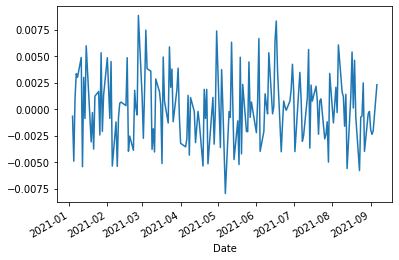

In [93]:
raw_data.loc['2021'].plot()

In [151]:
test_data = torch.tensor(raw_data[-14::]).view(1,1,14)
test_data = test_data.double()
test_data

tensor([[[ 0.0001,  0.0046, -0.0007, -0.0058, -0.0008, -0.0006,  0.0025,
          -0.0040, -0.0004, -0.0002, -0.0019, -0.0024, -0.0021,  0.0023]]],
       dtype=torch.float64)

In [150]:
model.eval() 
pred = model(test_data)

RuntimeError: expected scalar type Double but found Float

In [153]:
result['prediction']

,Prediction,Ground_truth
0,-0.003548,-0.003799
1,0.001139,-0.001850
2,-0.001500,-0.004039
3,-0.006583,0.002840
4,-0.002508,0.001635
...,...,...
123,-0.002068,-0.001945
124,0.002926,-0.002382
125,-0.000334,-0.002062
126,-0.005957,0.002301
